
# Projet : Prédiction des Prix des Voitures d'Occasion


Ce projet vise à prédire le prix de vente de voitures d'occasion à partir de leurs caractéristiques telles que l'année, le kilométrage, le type de carburant, etc. Nous suivrons les étapes suivantes :

1. Exploration des données (EDA)
2. Préparation des données
3. Modélisation avec différents algorithmes
4. Enregistrement du modèle avec MLflow
5. Déploiement de l'API avec FastAPI
6. Explicabilité des modèles avec SHAP


# Étape 1 : Chargement des Données


Nous commençons par charger les données dans un DataFrame df et explorons les premières lignes pour comprendre sa structure.



In [3]:
import pandas as pd

# Chargement du dataset
df = pd.read_csv('car.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner



# Étape 2 : Exploration des Données (EDA)



Statistiques descriptives
Les statistiques descriptives permettent de résumer les distributions des colonnes numériques principales. Cela nous aide à repérer des valeurs aberrantes ou des anomalies.



In [4]:
# Statistiques descriptives
df.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000




Visualisation des données
Un boxplot est utilisé pour détecter les anomalies dans les colonnes


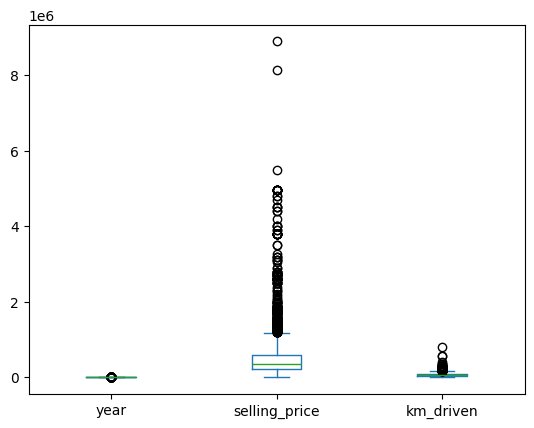

In [ ]:
# Boxplot pour détecter les anomalies
import matplotlib.pyplot as plt
import seaborn as sns

df.plot.box()
plt.show()


In [ ]:
# Visualisation avec Plotly
import plotly.express as px
fig = px.box(df, x="year", y="km_driven", color="selling_price")
fig.show()

Les deux graphiques montrent des anomalies significatives dans les données, notamment des véhicules avec des prix de vente ou des kilométrages exceptionnellement élevés.
Cela peut donc avoir pour conséquence une mauvaise représentation de notre modèle.



# Étape 3 : Transformation des Données


Nous préparons les données pour les modèles en encodant les colonnes catégoriques et en manipulant les colonnes nécessaires.



In [5]:
# Copie des données pour transformation
df1 = df.copy()

Nous vérifions combien de valeurs manquantes (NaN) il y a dans chaque colonne, afin de savoir si des données doivent être corrigées ou complétées avant de continuer.

In [ ]:
df1.isna().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0


In [ ]:
df1

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
4335,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


Nous vérifions les types de nos différentes classes.

In [ ]:
df1.dtypes

,0
name,object
year,int64
selling_price,int64
km_driven,int64
fuel,object
seller_type,object
transmission,object
owner,object


In [6]:
from sklearn.compose import make_column_selector

In [9]:
import numpy as np

In [11]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

In [12]:
display(cat_selector(df1))
display(num_selector(df1))

['name', 'fuel', 'seller_type', 'transmission', 'owner']

['year', 'selling_price', 'km_driven']

Encodage des colonnes catégoriques

Chaque valeur textuelle est convertie en valeur numérique pour que les algorithmes de machine learning puissent traiter ces colonnes. Cela est essentiel car la plupart des modèles ne peuvent pas travailler directement avec des données non numériques.


In [13]:
df1['fuel'].replace({'Diesel': 0, 'Petrol': 1, 'LPG': 2, 'CNG': 3, 'Electric': 4}, inplace=True)
df1.replace({'Automatic': 0, 'Manual': 1}, inplace=True)
df1.replace({'First Owner': 0, 'Second Owner': 1, 'Third Owner': 2, 'Fourth & Above Owner': 3, 'Test Drive Car': 4}, inplace=True)
df1.replace({'Dealer': 0, 'Individual': 1, 'Trustmark Dealer': 2}, inplace=True)

<ipython-input-13-9053623a2ce4>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['fuel'].replace({'Diesel': 0, 'Petrol': 1, 'LPG': 2, 'CNG': 3, 'Electric': 4}, inplace=True)
<ipython-input-13-9053623a2ce4>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['fuel'].replace({'Diesel': 0, 'Petrol

 Création d'une nouvelle colonne "brand"

In [14]:
df1['brand'] = df1['name'].str.split().str[0]
df1.drop('name', axis=1, inplace=True)



Les colonnes catégoriques ont été encodées et une nouvelle colonne "brand" a été ajoutée pour représenter la marque de chaque voiture. Ces transformations permettent aux modèles d'analyser efficacement les relations entre les caractéristiques et le prix de vente.




In [ ]:
df1

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,2007,60000,70000,1,1,1,0,Maruti
1,2007,135000,50000,1,1,1,0,Maruti
2,2012,600000,100000,0,1,1,0,Hyundai
3,2017,250000,46000,1,1,1,0,Datsun
4,2014,450000,141000,0,1,1,1,Honda
...,...,...,...,...,...,...,...,...
4335,2014,409999,80000,0,1,1,1,Hyundai
4336,2014,409999,80000,0,1,1,1,Hyundai
4337,2009,110000,83000,1,1,1,1,Maruti
4338,2016,865000,90000,0,1,1,0,Hyundai



# Étape 4 : Création et Entraînement de Modèles


Nous testons différents modèles et pipelines pour trouver celui qui donne les meilleures performances.


In [15]:
#Modèle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

Dans un premier temps nous utilisons OneHotEncoder pour encoder notre classe brand car celle-ci comprend un nombre important de catégories

In [16]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_brand = encoder.fit_transform(df1[['brand']])
encoded_brand_df = pd.DataFrame(encoded_brand, columns=encoder.get_feature_names_out(['brand']))
x = pd.concat([df1, encoded_brand_df], axis=1)

In [ ]:
x

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand,brand_Ambassador,brand_Audi,...,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_OpelCorsa,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo
0,2007,60000,70000,1,1,1,0,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007,135000,50000,1,1,1,0,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012,600000,100000,0,1,1,0,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,250000,46000,1,1,1,0,Datsun,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,450000,141000,0,1,1,1,Honda,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,2014,409999,80000,0,1,1,1,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4336,2014,409999,80000,0,1,1,1,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4337,2009,110000,83000,1,1,1,1,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4338,2016,865000,90000,0,1,1,0,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y =  df1[['selling_price']]
x = x.drop(['brand', 'selling_price'], axis=1, errors='ignore')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Nous créons un modèle de régression linéaire , puis l'entraînons avec les données d'entraînement (X_train pour les caractéristiques et y_train pour les prix).

Le modèle apprend ainsi à prédire les prix en trouvant la meilleure relation linéaire entre les caractéristiques et les prix.

In [18]:
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

Nous calculons et affichons les scores (ou performances) du modèle de régression linéaire. Le score est exprimé en pourcentage :

clf.score(X_train, y_train) : Performance du modèle sur les données d'entraînement, pour vérifier s'il a bien appris.

clf.score(X_test, y_test) : Performance sur les données de test, pour évaluer comment le modèle se généralise à de nouvelles données.

In [19]:
print(clf.score(X_train, y_train)*100)
print(clf.score(X_test, y_test)*100)

71.19226868900441
52.77118360884139


In [20]:
print (X_test[0:1])
clf.predict(X_test[0:1])

      year  km_driven  fuel  seller_type  transmission  owner  \
3978  2010      80000     0            1             1      0   

      brand_Ambassador  brand_Audi  brand_BMW  brand_Chevrolet  ...  \
3978               0.0         0.0        0.0              0.0  ...   

      brand_Mercedes-Benz  brand_Mitsubishi  brand_Nissan  brand_OpelCorsa  \
3978                  0.0               0.0           0.0              0.0   

      brand_Renault  brand_Skoda  brand_Tata  brand_Toyota  brand_Volkswagen  \
3978            0.0          0.0         1.0           0.0               0.0   

      brand_Volvo  
3978          0.0  

[1 rows x 35 columns]


array([[233786.02840394]])

La première ligne (print(X_test[0:1])) affiche la première observation (ou ligne) des données de test, qui sera utilisée comme exemple pour prédire un prix.

La deuxième ligne (clf.predict(X_test[0:1])) utilise le modèle entraîné pour prédire le prix correspondant à cette observation. Cela permet de vérifier comment le modèle applique ce qu'il a appris à une donnée spécifique.

In [ ]:
df1.shape

(4340, 8)

OneHotEncoder crée une classe pour chaque marque présente dans notre dataset, nous allons cette fois ci utiliser OrdinalEncoder afin que chaque catégorie devienne un nombre

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

In [22]:
cat_tree_processor =  OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
)

num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

Nous mettons en place un transformateur (tree_processor) qui applique un prétraitement différent selon le type de colonne : les colonnes numériques sont traitées par num_tree_processor, et les colonnes catégoriques par cat_tree_processor.

make_column_transformer permet de traiter différentes colonnes de manière distincte. Ici, les colonnes numériques sont imputées avec la moyenne et les colonnes catégoriques sont encodées avec OrdinalEncoder.

 Cela permet de simplifier le prétraitement des données, surtout lorsque différentes transformations sont nécessaires selon le type de colonne.

In [23]:
tree_processor = make_column_transformer(
     (num_tree_processor , num_selector),
    (cat_tree_processor, cat_selector),

)

tree_processor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd840>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd690>)])

In [24]:
y = df1.selling_price
x = df1.drop('selling_price', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state=42)

## **Ajout de modèles pour la pipeline**

# Pipeline pour Random Forest



In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

rfr_pipeline = make_pipeline(tree_processor, RandomForestRegressor(n_estimators=100, random_state=42))
rfr_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd840>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd690>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [26]:
rfr_pipeline.fit(x_train, y_train)

print("Score Random Forest :")
print(rfr_pipeline.score(x_train, y_train) * 100)
print(rfr_pipeline.score(x_test, y_test) * 100)

Score Random Forest :
96.32181761266644
66.81361757386257


Le modèle apprend par coeur les données comprend à peu près on essaie un autre modèle pour éviter l'overfitting

# Pipeline pour Lasso Regression



In [27]:
from sklearn.linear_model import LassoCV

Lasso_pipeline = make_pipeline(tree_processor, LassoCV())
Lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd840>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd690>)])),
                ('lassocv', LassoCV())])

In [28]:
Lasso_pipeline = Lasso_pipeline.fit(x_train, y_train)

In [29]:
print(Lasso_pipeline.score(x_train, y_train)* 100)
print(Lasso_pipeline.score(x_test, y_test) * 100)

3.596612426878709
4.037270370603441


**Le résultat n'est pas top** !!! le modèle n'explique que 3-4% de la variance dans les données.

Le problème peut être intrinsèquement difficile à modéliser linéairement.

Il pourrait y avoir un manque de caractéristiques prédictives pertinentes.

Les données pourraient nécessiter plus de prétraitement ou de feature engineering.

La régression Lasso pourrait être trop restrictive pour ce problème particulier.




#Standard Scaler

StandardScaler est utilisé pour normaliser les données, ce qui est souvent nécessaire pour des modèles linéaires comme LassoCV.

In [30]:
from sklearn.preprocessing import StandardScaler

In [71]:
cat_linear_processor = OrdinalEncoder(handle_unknown="use_encoded_value",
    unknown_value=-1,
)
num_linear_processor = make_pipeline(StandardScaler(),SimpleImputer(strategy="mean", add_indicator=True)
)
linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector),
    (cat_linear_processor, cat_selector),
)

linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cdf60>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd690>)])

In [72]:
Lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
Lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cdf60>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd690>)])),
                ('lassocv', LassoCV())])

In [73]:
Lasso_pipeline = Lasso_pipeline.fit(x_train, y_train)

print(Lasso_pipeline.score(x_train, y_train)* 100)
print(Lasso_pipeline.score(x_test, y_test) * 100)

45.70917967160657
39.685863434212806


Nous obtenons de meilleurs résultats.

In [74]:
Lasso_pipeline.predict(x_test[0:1])

array([374785.77324644])

In [34]:
Lasso_pipeline.named_steps['columntransformer'].get_feature_names_out()


array(['pipeline__year', 'pipeline__km_driven', 'pipeline__fuel',
       'pipeline__seller_type', 'pipeline__transmission',
       'pipeline__owner', 'ordinalencoder__brand'], dtype=object)

In [35]:
Lasso_pipeline.named_steps['lassocv'].coef_

array([ 166251.53302233,  -36525.53374349, -135504.20900102,
        -12040.10706848, -274582.10110008,   -7318.83150169,
         -3326.12296493])

#Modèle de Classification
# Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipeline = make_pipeline(tree_processor, RandomForestClassifier(n_estimators=100, random_state=42))
rfr_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd840>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd690>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [37]:
rfc_pipeline.fit(x_train, y_train)

print(rfc_pipeline.score(x_train, y_train)* 100)
print(rfc_pipeline.score(x_test, y_test) * 100)

89.3721198156682
25.57603686635945


In [38]:
rfc_pipeline.named_steps['randomforestclassifier'].feature_importances_


array([0.19279432, 0.4517613 , 0.02918433, 0.02719073, 0.01736342,
       0.06256641, 0.2191395 ])

In [39]:
rfc_pipeline.named_steps['columntransformer'].get_feature_names_out()


array(['simpleimputer__year', 'simpleimputer__km_driven',
       'simpleimputer__fuel', 'simpleimputer__seller_type',
       'simpleimputer__transmission', 'simpleimputer__owner',
       'ordinalencoder__brand'], dtype=object)

In [40]:
rfc_pipeline.predict(x_test[0:1])

array([100000])

  # Forêts aléatoires avec réglage des hyperparamètres
  
   On essaie `RandomForestRegressor` à nouveau mais avec une recherche d'hyperparamètres (comme `GridSearchCV` ou `RandomizedSearchCV` de scikit-learn) pour trouver des paramètres plus adaptés et réduire le surapprentissage.

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 500],
    'randomforestregressor__max_depth': [5, 10, 15, None],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
}
rfr_pipeline = make_pipeline(tree_processor, RandomForestRegressor(random_state=42))

random_search = RandomizedSearchCV(rfr_pipeline, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
random_search.fit(x_train, y_train)

print(random_search.best_estimator_.score(x_train, y_train)*100)
print(random_search.best_estimator_.score(x_test, y_test)*100)

90.53695552031981
64.65237914657307


On constate de l'overfitting. Essayons un autre modèle...

#Gradient Boosting Machines (GBM)
 Des algorithmes comme GradientBoostingRegressor (de scikit-learn), XGBoost, LightGBM ou CatBoost peuvent souvent mieux capturer les relations non linéaires dans les données.

  Ils sont robustes et moins sujets au surapprentissage que les Random Forest.

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipeline = make_pipeline(tree_processor, GradientBoostingRegressor(n_estimators=100, random_state=42))
gbr_pipeline.fit(x_train, y_train)
print(gbr_pipeline.score(x_train, y_train)*100)
print(gbr_pipeline.score(x_test, y_test)*100)

84.10797518761836
64.7806352005847



On a toujours de l'overfitting. Il est cependant moins présent au vu de l'écart reduit ici à 20% entre le score d'entraîenment et de test.


De plus, nous avons testé plusieurs modèles, notamment RandomForestRegressor et LassoCV.

Random Forest est un modèle basé sur des arbres de décision, robuste face à des données non linéaires et souvent performant sans nécessiter de normalisation préalable.

En revanche, LassoCV, qui effectue une régularisation L1, est utile pour réduire l'impact des variables moins pertinentes.


# PCA

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

gb_pipeline_with_PCA = make_pipeline(tree_processor, PCA(n_components=0.95),GradientBoostingRegressor(n_estimators=100, random_state=42))
gb_pipeline_with_PCA

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd840>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9e61cd690>)])),
                ('pca', PCA(n_components=0.95)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=42))])

In [77]:
gb_pipeline_with_PCA = gb_pipeline_with_PCA.fit(x_train, y_train)

In [78]:
y_pred_pca = gb_pipeline_with_PCA.predict(x_test)

In [79]:
print("Train score", gb_pipeline_with_PCA.score(x_train, y_train) * 100)
print("Test score", gb_pipeline_with_PCA.score(x_test, y_test) * 100)

Train score 26.4171024544968
Test score 6.863402282093533


Étant donné le score obtenu, chaque colonne apporte une information précieuse pour prédire le prix de vente. L'utilisation du PCA, qui réduit la dimensionnalité sans considérer la variable cible, risque d'éliminer des informations cruciales. Cela pourrait entraîner des prédictions moins précises.

# Étape 5: Comparaison entre prédictions et valeurs réelles

Notre modèle le plus représentatif de nos données est le GradientBoostingRegressor. Nous allons nous basé dessus pour faire notre comparaison.

In [63]:
# Prediction de la valeur dans le set de test
y_pred = gbr_pipeline.predict(x_test)

In [64]:
y_pred_df = pd.DataFrame(y_pred, columns=["selling_price_pred"])

In [65]:
df_car_predict = pd.concat([x_test.reset_index(), y_test.reset_index(), y_pred_df], axis=1)
df_car_predict

,index,year,km_driven,fuel,seller_type,transmission,owner,brand,index,selling_price,selling_price_pred
0,3978,2010,80000,0,1,1,0,Tata,3978,165000,2.224989e+05
1,1448,2019,27000,1,1,1,0,Renault,1448,250000,4.746951e+05
2,2664,2008,41723,1,1,1,1,Hyundai,2664,120000,1.607137e+05
3,17,2014,141000,0,1,1,1,Honda,17,450000,4.688649e+05
4,1634,2016,60000,0,1,0,1,Mahindra,1634,730000,1.392482e+06
...,...,...,...,...,...,...,...,...,...,...,...
863,3468,2007,60000,1,1,1,2,Maruti,3468,130000,8.983973e+04
864,3164,2015,120000,0,1,1,0,Maruti,3164,350000,4.879707e+05
865,416,2011,40000,0,1,1,1,Maruti,416,150000,2.589611e+05
866,1616,2017,6480,1,2,1,0,Toyota,1616,650000,1.357925e+06


In [66]:
df_car_predict['y_error'] =  ((df_car_predict.selling_price - df_car_predict.selling_price_pred) / df_car_predict.selling_price_pred) * 100
df_car_predict

,index,year,km_driven,fuel,seller_type,transmission,owner,brand,index,selling_price,selling_price_pred,y_error
0,3978,2010,80000,0,1,1,0,Tata,3978,165000,2.224989e+05,-25.842336
1,1448,2019,27000,1,1,1,0,Renault,1448,250000,4.746951e+05,-47.334615
2,2664,2008,41723,1,1,1,1,Hyundai,2664,120000,1.607137e+05,-25.333059
3,17,2014,141000,0,1,1,1,Honda,17,450000,4.688649e+05,-4.023523
4,1634,2016,60000,0,1,0,1,Mahindra,1634,730000,1.392482e+06,-47.575611
...,...,...,...,...,...,...,...,...,...,...,...,...
863,3468,2007,60000,1,1,1,2,Maruti,3468,130000,8.983973e+04,44.702130
864,3164,2015,120000,0,1,1,0,Maruti,3164,350000,4.879707e+05,-28.274382
865,416,2011,40000,0,1,1,1,Maruti,416,150000,2.589611e+05,-42.076235
866,1616,2017,6480,1,2,1,0,Toyota,1616,650000,1.357925e+06,-52.132853


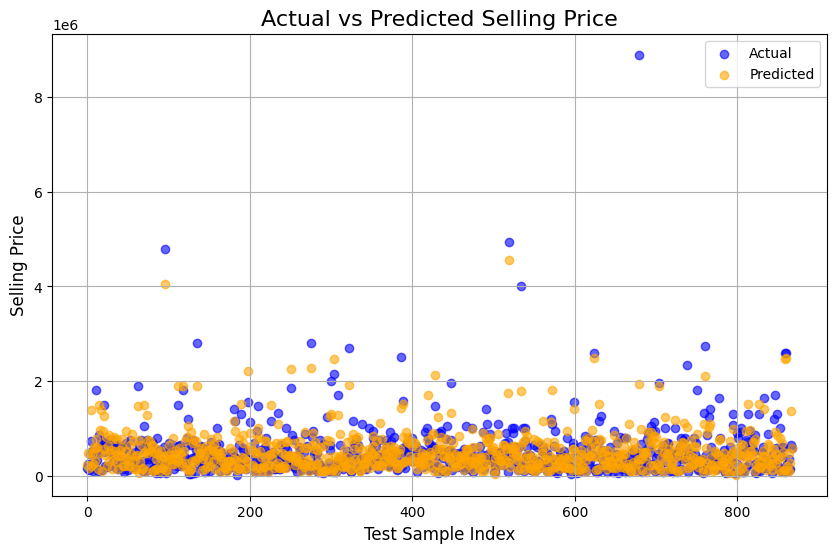

In [67]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot actual values
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='Actual')

# Plot predicted values
plt.scatter(range(len(y_pred)), y_pred, color='orange', alpha=0.6, label='Predicted')

# Adding titles and labels
plt.title("Actual vs Predicted Selling Price", fontsize=16)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("Selling Price", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Essayons de mieux constater l'écart en affichant la différence entre la valeur attendue et la prédiction.

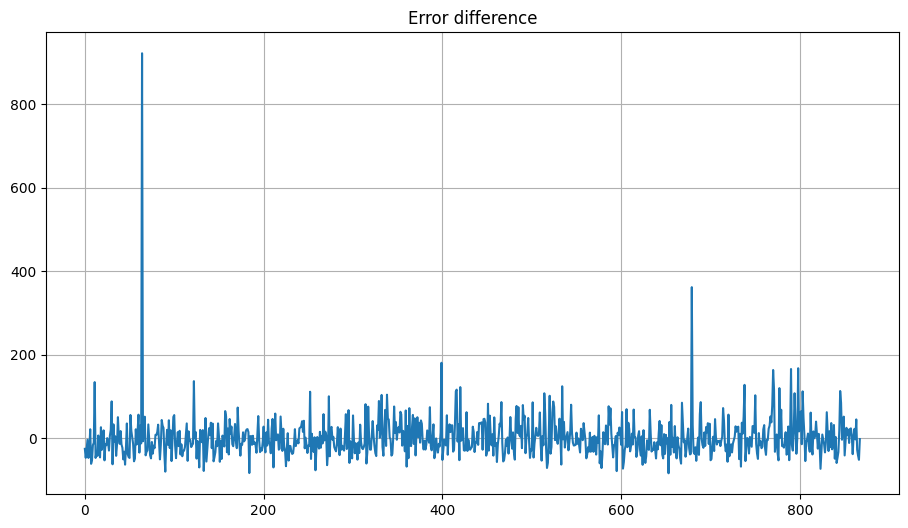

In [68]:
import matplotlib.pyplot as plt


plt.figure(figsize=(11, 6))
plt.plot(df_car_predict['y_error'])

plt.title('Error difference')
plt.grid(True)

plt.show()

Le modèle fonctionne bien pour la majorité des prédictions, mais certains points présentent des erreurs élevées. Une analyse approfondie est nécessaire pour comprendre si ces écarts proviennent des données ou des limitations du modèle, afin d'améliorer sa précision.


# Étape 6 : Enregistrement du Modèle avec MLflow


MLflow est utilisé pour gérer les modèles, versionner et suivre leurs performances de manière centralisée.




In [69]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [70]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Car Price Prediction")

with mlflow.start_run():
    mlflow.sklearn.log_model(rfr_pipeline, artifact_path="random_forest_pipeline")
    mlflow.log_metric("train_score", rfr_pipeline.score(X_train, y_train))
    mlflow.log_metric("test_score", rfr_pipeline.score(X_test, y_test))

print("Modèle Random Forest enregistré avec succès dans MLflow.")

MlflowException: API request to endpoint /api/2.0/mlflow/experiments/get-by-name failed with error code 404 != 200. Response body: '<!DOCTYPE HTML>
<html>

<head>
    <meta charset="utf-8">

    <title>Jupyter Notebook</title>
    <link id="favicon" rel="shortcut icon" type="image/x-icon" href="/static/base/images/favicon.ico?v=50afa725b5de8b00030139d09b38620224d4e7dba47c07ef0e86d4643f30c9bfe6bb7e1a4a1c561aa32834480909a4b6fe7cd1e17f7159330b6b5914bf45a880">
    <meta http-equiv="X-UA-Compatible" content="IE=edge" />
    <link rel="stylesheet" href="/static/components/jquery-ui/dist/themes/smoothness/jquery-ui.min.css?v=aeef962be7038761e5174f91e2da776c640f789e9802621178606b759506b273d9a97f189a9262b19ac5b511f70a662d8c5e2bf2fb258ae11c3c2ee1e07c6abd" type="text/css" />
    <link rel="stylesheet" href="/static/components/jquery-typeahead/dist/jquery.typeahead.min.css?v=5edf53bf6bb9c3b1ddafd8594825a7e2ed621f19423e569c985162742f63911c09eba2c529f8fb47aebf27fafdfe287d563347f58c1126b278189a18871b6a9a" type="text/css" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    
    

    <link rel="stylesheet" href="/static/style/style.min.css?v=e1ab1c38b672063a6541baf468c83345cd0f509729783ec9b7ccb64073004f5f056110c82c28aefbf3dbf32e0e040f05b8f0420bc411b669ed3d4f07511812ca" type="text/css"/>
    
<style type="text/css">
/* disable initial hide */
div#header, div#site {
    display: block;
}
</style>

    <link rel="stylesheet" href="/custom/custom.css" type="text/css" />
    <script src="/static/components/es6-promise/promise.min.js?v=bea335d74136a63ae1b5130f5ac9a50c6256a5f435e6e09fef599491a84d834a8b0f011ca3eaaca3b4ab6a2da2d3e1191567a2f171e60da1d10e5b9d52f84184" type="text/javascript" charset="utf-8"></script>
    <script src="/static/components/react/react.production.min.js?v=9a0aaf84a316c8bedd6c2ff7d5b5e0a13f8f84ec02442346cba0b842c6c81a6bf6176e64f3675c2ebf357cb5bb048e0b527bd39377c95681d22468da3d5de735" type="text/javascript"></script>
    <script src="/static/components/react/react-dom.production.min.js?v=6fc58c1c4736868ff84f57bd8b85f2bdb985993a9392718f3b4af4bfa10fb4efba2b4ddd68644bd2a8daf0619a3844944c9c43f8528364a1aa6fc01ec1b8ae84" type="text/javascript"></script>
    <script src="/static/components/create-react-class/index.js?v=894ad57246e682b4cfbe7cd5e408dcd6b38d06af4de4f3425991e2676fdc2ef1732cbd19903104198878ae77de12a1996de3e7da3a467fb226bdda8f4618faec" type="text/javascript"></script>
    <script src="/static/components/requirejs/require.js?v=d37b48bb2137faa0ab98157e240c084dd5b1b5e74911723aa1d1f04c928c2a03dedf922d049e4815f7e5a369faa2e6b6a1000aae958b7953b5cc60411154f593" type="text/javascript" charset="utf-8"></script>
    <script>
      require.config({
          
          urlArgs: "v=20250112105354",
          
          baseUrl: '/static/',
          paths: {
            'auth/js/main': 'auth/js/main.min',
            custom : '/custom',
            nbextensions : '/nbextensions',
            kernelspecs : '/kernelspecs',
            underscore : 'components/underscore/underscore-min',
            backbone : 'components/backbone/backbone-min',
            jed: 'components/jed/jed',
            jquery: 'components/jquery/jquery.min',
            json: 'components/requirejs-plugins/src/json',
            text: 'components/requirejs-text/text',
            bootstrap: 'components/bootstrap/dist/js/bootstrap.min',
            bootstraptour: 'components/bootstrap-tour/build/js/bootstrap-tour.min',
            'jquery-ui': 'components/jquery-ui/dist/jquery-ui.min',
            moment: 'components/moment/min/moment-with-locales',
            codemirror: 'components/codemirror',
            termjs: 'components/xterm.js/xterm',
            typeahead: 'components/jquery-typeahead/dist/jquery.typeahead.min',
          },
          map: { // for backward compatibility
              "*": {
                  "jqueryui": "jquery-ui",
              }
          },
          shim: {
            typeahead: {
              deps: ["jquery"],
              exports: "typeahead"
            },
            underscore: {
              exports: '_'
            },
            backbone: {
              deps: ["underscore", "jquery"],
              exports: "Backbone"
            },
            bootstrap: {
              deps: ["jquery"],
              exports: "bootstrap"
            },
            bootstraptour: {
              deps: ["bootstrap"],
              exports: "Tour"
            },
            "jquery-ui": {
              deps: ["jquery"],
              exports: "$"
            }
          },
          waitSeconds: 30,
      });

      require.config({
          map: {
              '*':{
                'contents': 'services/contents',
              }
          }
      });

      // error-catching custom.js shim.
      define("custom", function (require, exports, module) {
          try {
              var custom = require('custom/custom');
              console.debug('loaded custom.js');
              return custom;
          } catch (e) {
              console.error("error loading custom.js", e);
              return {};
          }
      })

      // error-catching custom-preload.js shim.
      define("custom-preload", function (require, exports, module) {
          try {
              var custom = require('custom/custom-preload');
              console.debug('loaded custom-preload.js');
              return custom;
          } catch (e) {
              console.error("error loading custom-preload.js", e);
              return {};
          }
      })

    document.nbjs_translations = {"domain": "nbjs", "locale_data": {"nbjs": {"": {"domain": "nbjs"}}}};
    document.documentElement.lang = navigator.language.toLowerCase();
    </script>

    
    

</head>

<body class=""
 
  
 
dir="ltr">

<noscript>
    <div id='noscript'>
      Jupyter Notebook requires JavaScript.<br>
      Please enable it to proceed. 
  </div>
</noscript>

<div id="header" role="navigation" aria-label="Top Menu">
  <div  id="newsId" style="display: none">
    
    <div class="alert alert-info" role="alert">
      <div style="display: flex">
        <div>
          <span class="label label-warning">UPDATE</span>
          Read <a href="https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html" style="text-decoration: underline;" target="_blank">the migration plan</a> to Notebook 7 to learn about the new features and the actions to take if you are using extensions
          -
          Please note that updating to Notebook 7 might break some of your extensions.
        </div>
        <div style="margin-left: auto;">
          <a href="" onclick="alert('This message will not be shown anymore.'); return false;">
            <button type="button" class="btn btn-default btn-xs" id="dontShowId">
              Don't show anymore
            </button>
          </a>
        </div>
      </div>
    </div>
    
  </div>
  <div id="header-container" class="container">
  <div id="ipython_notebook" class="nav navbar-brand"><a href="/tree" title='dashboard'>
      <img src='/static/base/images/logo.png?v=a2a176ee3cee251ffddf5fa21fe8e43727a9e5f87a06f9c91ad7b776d9e9d3d5e0159c16cc188a3965e00375fb4bc336c16067c688f5040c0c2d4bfdb852a9e4' alt='Jupyter Notebook'/>
  </a></div>

  
  
  
  
  
  


  
  
  </div>
  <div class="header-bar"></div>

  
  
</div>

<div id="site">


<div class="error">
    
    <h1>404 : Not Found</h1>
    
    
<p>You are requesting a page that does not exist!</p>

</div>


</div>







<script type='text/javascript'>
require(['jquery'], function($) {
  // scroll long tracebacks to the bottom
  var tb = $(".traceback")[0];
  tb.scrollTop = tb.scrollHeight;
});
</script>


<script type='text/javascript'>
  function _remove_token_from_url() {
    if (window.location.search.length <= 1) {
      return;
    }
    var search_parameters = window.location.search.slice(1).split('&');
    for (var i = 0; i < search_parameters.length; i++) {
      if (search_parameters[i].split('=')[0] === 'token') {
        // remote token from search parameters
        search_parameters.splice(i, 1);
        var new_search = '';
        if (search_parameters.length) {
          new_search = '?' + search_parameters.join('&');
        }
        var new_url = window.location.origin + 
                      window.location.pathname + 
                      new_search + 
                      window.location.hash;
        window.history.replaceState({}, "", new_url);
        return;
      }
    }
  }
  _remove_token_from_url();
  sys_info = {"notebook_version": "6.5.5", "notebook_path": "/usr/local/lib/python3.10/dist-packages/notebook", "commit_source": "", "commit_hash": "", "sys_version": "3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]", "sys_executable": "/usr/bin/python3", "sys_platform": "linux", "platform": "Linux-6.1.85+-x86_64-with-glibc2.35", "os_name": "posix", "default_encoding": "utf-8"};
  document.addEventListener('DOMContentLoaded', function () {
    const newsId = document.querySelector('#newsId');
    const dontShowId = document.querySelector('#dontShowId');
    const showNotebookNews = localStorage.getItem('showNotebookNews');
    dontShowId.addEventListener('click', () => {
      localStorage.setItem('showNotebookNews', false);
      newsId.style.display = 'none';
    });
    if (!showNotebookNews) newsId.style.display = 'inline';
  });
</script>
</body>

</html>'


# Étape 7 : Déploiement avec FastAPI


FastAPI est utilisé pour déployer les modèles sous forme d'API. Cela permet à d'autres applications de faire des prédictions en envoyant des requêtes HTTP.



In [ ]:
!pip install fastapi

In [ ]:
from fastapi import FastAPI

app = FastAPI()

@app.get("/status")
def status():
    return {"status": "Le modèle est prêt pour les prédictions."}



La fonction predict prend en entrée les caractéristiques d'un véhicule (année, kilométrage, type de carburant, etc.),
    les transforme au format attendu par le modèle, et retourne une prédiction du prix de vente estimé.

In [ ]:
@app.post("/predict")
def predict(year: int, km_driven: int, fuel: int, transmission: int, owner: int, brand: int):
    input_data = pd.DataFrame([[year, km_driven, fuel, transmission, owner, brand]],
                              columns=['year', 'km_driven', 'fuel', 'transmission', 'owner', 'brand'])
    prediction = rfr_pipeline.predict(input_data)
    return {"predicted_price": prediction[0]}


# Étape 8 : Ajout de SHAP pour l'Explicabilité


SHAP est une bibliothèque qui permet de comprendre les décisions des modèles. Les graphiques comme `summary_plot` montrent quelles caractéristiques influencent le plus les prédictions.



Dans un graphique SHAP, chaque point représente une instance (une observation). L'axe horizontal indique l'impact de la caractéristique sur la prédiction, positif ou négatif. Les couleurs (rouge et bleu) montrent si la valeur de la caractéristique est élevée ou basse. Par exemple, des points rouges à droite indiquent une forte valeur d'une caractéristique qui augmente la prédiction.

Cela permet de comprendre quelles caractéristiques sont les plus importantes dans les décisions du modèle.

In [ ]:
!pip install shap

In [ ]:
import shap

SHAP permet d'expliquer les prédictions du modèle en attribuant à chaque caractéristique une valeur qui représente son impact positif ou négatif sur la prédiction.


In [ ]:
explainer = shap.Explainer(rfr_pipeline.predict, X_train)
shap_values = explainer(X_test)

Le graphique summary_plot présente les caractéristiques les plus influentes sur l'ensemble des prédictions, ainsi que leurs impacts respectifs (positifs ou négatifs).


In [ ]:
shap.summary_plot(shap_values, X_test)


# Conclusion


Ce projet illustre tout le cycle de vie d'un modèle machine learning : exploration des données, création, entraînement, enregistrement, déploiement, et explicabilité.

Les outils utilisés comme MLflow et SHAP rendent ce processus robuste et transparent.

**Prochaines étapes :** essayer d'autres modèles, explorer des approches comme Gradient Boosting, et améliorer l'expérience utilisateur.

